# Find unbound states to pair with the bound states

### Imports

In [1]:
%load_ext lab_black
# Python standard library
from glob import glob
import os
import socket
import sys

# 3rd party library imports
import dask
import matplotlib.pyplot as plt
import pandas as pd
import pyrosetta
import numpy as np
import scipy
import seaborn as sns
from tqdm.auto import tqdm  # jupyter compatible progress bar

tqdm.pandas()  # link tqdm to pandas
# Notebook magic
# save plots in the notebook
%matplotlib inline
# reloads modules automatically before executing cells
%load_ext autoreload
%autoreload 2
print(f"running in directory: {os.getcwd()}")  # where are we?
print(f"running on node: {socket.gethostname()}")  # what node are we on?

running in directory: /mnt/projects/crispy_shifty/projects/crispy_shifty_junctions
running on node: dig120


### Set working directory to the root of the crispy_shifty repo

In [2]:
os.chdir("/projects/crispy_shifty")

### Fix the paths
Necessary because we copied these designs from perlmutter

In [3]:
from crispy_shifty.utils.io import fix_path_prefixes

folded = os.path.join(
    os.getcwd(),
    "projects/crispy_shifty_junctions/03_fold_bound_states/folded_states.list",
)
new_folded = fix_path_prefixes(
    find="/pscratch/sd/p/pleung",
    replace="/mnt/projects/crispy_shifty/projects/crispy_shifty_junctions",
    file=folded,
    overwrite=True,
)

/projects/crispy_shifty/envs/crispy/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Pair the designed bound states

In [ ]:
from crispy_shifty.utils.io import gen_array_tasks

simulation_name = "04_pair_bound_states"
design_list_file = os.path.join(
    os.getcwd(),
    "projects/crispy_shifty_junctions/03_fold_bound_states/folded_states.list",
)
output_path = os.path.join(os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}")

options = " ".join(
    [
        "out:level 200",
        "corrections::beta_nov16 true",
        "indexed_structure_store:fragment_store /net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    ]
)

extra_kwargs = {
    "reference_csv": "/mnt/projects/crispy_shifty/scaffolds/02_make_free_states/free_state_0s.csv",
}

gen_array_tasks(
    distribute_func="crispy_shifty.protocols.states.pair_bound_state",
    design_list_file=design_list_file,
    output_path=output_path,
    queue="short",
    memory="4G",
    nstruct=1,
    nstruct_per_task=10,
    options=options,
    extra_kwargs=extra_kwargs,
    simulation_name=simulation_name,
)

### Collect scorefiles of the paired bound states and concatenate

In [4]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import collect_score_file

simulation_name = "04_pair_bound_states"
output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
)

if not os.path.exists(os.path.join(output_path, "scores.json")):
    collect_score_file(output_path, "scores")

### Load resulting concatenated scorefile

In [5]:
sys.path.insert(0, "/projects/crispy_shifty")
from crispy_shifty.utils.io import parse_scorefile_linear

output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
)

if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df = parse_scorefile_linear(os.path.join(output_path, "scores.json"))

### Dump scores_df as a CSV and then reload, for performance reasons

In [6]:
if not os.path.exists(os.path.join(output_path, "scores.csv")):
    scores_df.to_csv(os.path.join(output_path, "scores.csv"))

scores_df = pd.read_csv(os.path.join(output_path, "scores.csv"), index_col="Unnamed: 0")

### Setup for plotting

In [7]:
sns.set(
    context="talk",
    font_scale=1,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)

### Data exploration
Gonna remove the Rosetta sfxn scoreterms for now

In [8]:
from crispy_shifty.protocols.design import beta_nov16_terms

scores_df = scores_df[
    [term for term in scores_df.columns if term not in beta_nov16_terms]
]
print(len(scores_df))

1040783


In [9]:
print(list(scores_df.columns))

['bb_clash', 'bb_clash_delta', 'bb_clash_delta_x', 'best_average_DAN_plddts', 'best_average_plddts', 'best_model', 'best_ptm', 'best_rmsd_to_input', 'buns_parent', 'cms_AcB', 'cms_AnAc', 'cms_AnAcB', 'cms_AnB', 'designed_by', 'docked_helix', 'dssp', 'elapsed_time', 'exposed_hydrophobics_parent', 'geometry_parent', 'holes_all_parent', 'holes_core_parent', 'loop_dist', 'loop_sc', 'looped_length', 'mean_pae', 'mean_pae_interaction', 'mean_pae_interaction_AB', 'mean_pae_interaction_BA', 'mean_pae_intra_chain', 'mean_pae_intra_chain_A', 'mean_pae_intra_chain_B', 'mean_plddt', 'mismatch_probability_parent', 'model', 'mpnn_design_area', 'mpnn_temperature', 'new_loop_str', 'pTMscore', 'packstat_parent', 'parent', 'parent_length', 'path_in', 'pdb', 'pivot_helix', 'pre_break_helix', 'recycles', 'rmsd_to_reference', 'sap_parent', 'sc_AcB', 'sc_AnAc', 'sc_AnAcB', 'sc_AnB', 'sc_all_parent', 'scaffold_type', 'score', 'score_per_res', 'score_per_res_parent', 'score_per_res_x', 'seed', 'shift', 'ss_sc

In [10]:
from crispy_shifty.utils.plotting import histplot_df, pairplot_df

to_plot = [
    "bb_clash_delta_x",
    "score_per_res_x",
]
print(to_plot)

['bb_clash_delta_x', 'score_per_res_x']


### Filter extreme outliers and change some dtypes

In [11]:
scores_df["bb_clash_delta_x"] = scores_df["bb_clash_delta_x"].astype(float)
scores_df["score_per_res_x"] = scores_df["score_per_res_x"].astype(float)

query = "bb_clash_delta_x < 500 and score_per_res_x < 0"
sample_df = scores_df.query(query)

### Plot loop scores

2it [00:04,  2.33s/it]


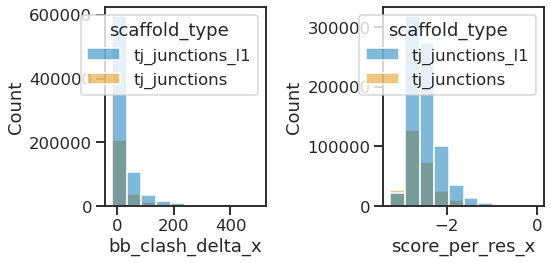

In [12]:
cols = [
    "bb_clash_delta_x",
    "score_per_res_x",
]
the_fig = histplot_df(
    df=sample_df,
    cols=cols,
    bins=10,
    hue="scaffold_type",
)
plt.savefig(os.path.join(output_path, "loop_scores.png"))

<Figure size 576x576 with 0 Axes>

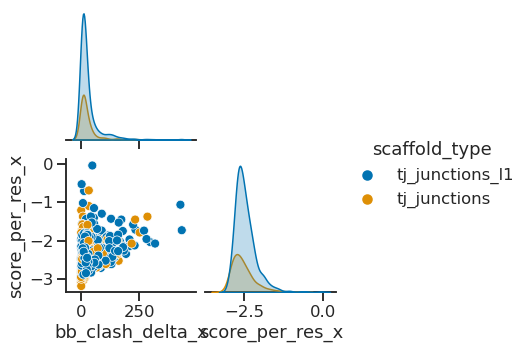

In [13]:
the_fig = pairplot_df(
    df=sample_df.sample(1000, random_state=0),
    cols=cols,
    hue="scaffold_type",
)
plt.savefig(os.path.join(output_path, "loop_scores_paired.png"))

### Filter out obviously bad decoys

In [14]:
query = "bb_clash_delta_x < 200 and score_per_res_x < -1.5"
filtered = scores_df.query(query)
len(filtered)

1003517

In [15]:
len(set(filtered.state.values))

18393

### Calculate delta Rg and angle between X and unbound Y
Also individual angles - use Arvind's algorithms for angles

In [16]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster


def row2results(row: pd.Series) -> dict:
    import sys
    import pyrosetta

    pyrosetta.distributed.maybe_init()
    sys.path.insert(0, "/projects/crispy_shifty")
    from crispy_shifty.protocols.cleaning import path_to_pose_or_ppose
    from crispy_shifty.protocols.states import (
        angle,
        delta_rg,
        hinge_angles,
        range_CA_align,
    )

    # following is safe because row will have exactly one name
    state = next(path_to_pose_or_ppose(row.name, pack_result=False))
    chains = list(state.split_by_chain())
    x, y = chains[-1], chains[0]
    delta_rg_hinge = delta_rg(x, y)
    new_loop_str = row["new_loop_str"]
    midpoint = int(new_loop_str.split(",")[0])
    x_angle, y_angle, angle_between = hinge_angles(state, midpoint)
    to_return = {
        "delta_rg": delta_rg_hinge,
        "x_angle": x_angle,
        "y_angle": y_angle,
        "angle_between": angle_between,
    }
    return to_return


simulation_name = "04_pair_bound_states"
output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
)
os.makedirs(output_path, exist_ok=True)
if not os.path.exists(os.path.join(output_path, "filtered.csv")):
    pyrosetta.init()

    futures, results = {}, {}

    if __name__ == "__main__":
        # configure SLURM cluster as a context manager
        with SLURMCluster(
            cores=1,
            processes=1,
            job_cpu=1,
            memory="2GB",
            queue="long",
            walltime="23:00:00",
            death_timeout=120,
            local_directory="$TMPDIR",  # spill worker litter on local node temp storage
            log_directory="/mnt/home/pleung/logs/slurm_logs",
            extra=["--lifetime", "23h", "--lifetime-stagger", "5m"],
        ) as cluster:
            print(cluster.job_script())
            # scale between 1-300 workers,
            cluster.adapt(
                minimum=1,
                maximum=300,
                wait_count=999,  # Number of consecutive times that a worker should be suggested for removal it is removed
                interval="5s",  # Time between checks
            )
            # setup a client to interact with the cluster as a context manager
            with Client(cluster) as client:
                print(client)
                for i, r in filtered.iterrows():
                    futures[i] = client.submit(row2results, r)
                for i, pending in futures.items():
                    result = pending.result()
                    results[i] = result
                client.close()
            cluster.scale(0)
            cluster.close()
        print("distributed run complete")

### Dump the `filtered` with updated rg data

In [17]:
if not os.path.exists(os.path.join(output_path, "filtered.csv")):
    to_merge = pd.DataFrame.from_dict(results, orient="index")
    final = pd.concat([filtered, to_merge], axis=1)
    simulation_name = "04_pair_bound_states"
    output_path = os.path.join(
        os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
    )
    final.to_csv(os.path.join(output_path, "filtered.csv"), index_label="pdb_path")

### Read in Arvind's picks and combine them with one of each state and some random picks

In [18]:
simulation_name = "04_pair_bound_states"
output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
)
arvind_picks = os.path.join(output_path, "arvind_picks.list")
picks = []
with open(arvind_picks, "r") as f:
    for line in f:
        picks.append(line.rstrip())
# slice out arvind's picks
reduced = filtered.loc[~filtered.index.isin(picks)]
print(len(filtered))
print(len(reduced))
# get one of each state
state_samples = reduced.groupby("state").sample(1, random_state=0)
picks.extend(list(state_samples.index))
# remove picks from reduced set
reduced = reduced.loc[~reduced.index.isin(picks)]
print(len(reduced))
# top off to 50k
top_off = 50000 - len(picks)
picks.extend(list(reduced.sample(top_off, random_state=0).index))
final_picks = filtered.loc[picks]
len(final_picks)

1003517
994287
976034


50000

### Save a list of outputs

In [19]:
simulation_name = "04_pair_bound_states"
output_path = os.path.join(
    os.getcwd(), f"projects/crispy_shifty_junctions/{simulation_name}"
)

with open(os.path.join(output_path, "paired_states.list"), "w") as f:
    for path in tqdm(picks):
        print(path, file=f)

  0%|          | 0/50000 [00:00<?, ?it/s]